# 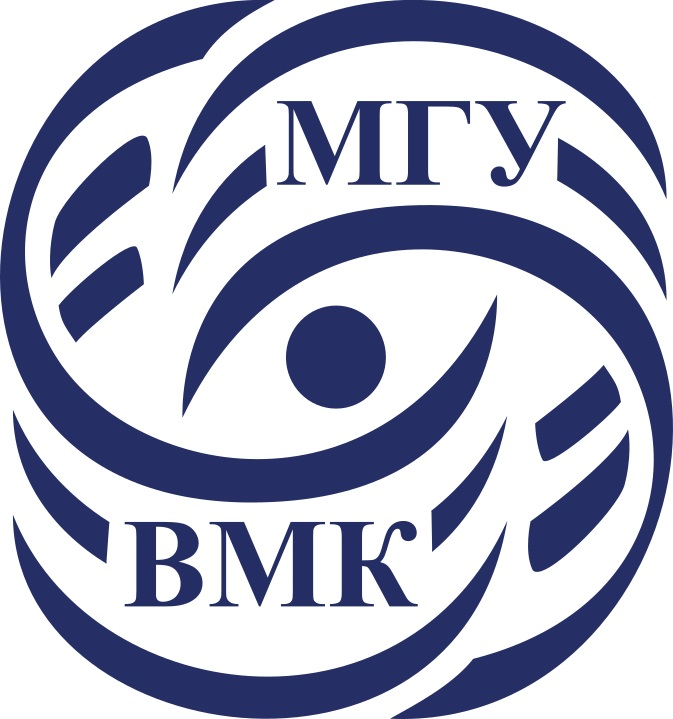

# Машинное обучение. ВМК МГУ

# Практическое задание 6: Линейные модели: классификация

## Уровень: <font color='SkyBlue'>**Базовый (Base)**</font>

# О формате сдачи

🔷 **<font color='plum'>При решении ноутбука используйте данный шаблон</font>**

    ✅ Можно добавлять новые ячейки любых типов
    ❌ Не нужно удалять текстовые ячейки c разметкой частей ноутбука и формулировками заданий


🔷 **<font color='plum'>При оценивании задач учитывается код</font>**

    ✅ Задания, в которых необходим код, обычно помечаются фразами "Your code here"/"Ваш код" и аналогичными
    ❌ Ответы на вопросы без сопутствующего кода оцениваются в 0 баллов
    ❌ Наличе работоспособного кода в ноутбуке, если на сказано иного, обязательно

🔷 **<font color='plum'>При оценивании задач учитываются выводы</font>**

    ✅ Задания, в которых необходимы выводы, обычно помечаются фразами Вывод"/"Ответ на вопрос"/"Ваш текст" и аналогичными
    ✅ Обычно выводы подразумевают под собой текстовый ответ (можно писать markdown, latex).
    ✅ Сопутствующие изображения, графики, таблички - приветствуются!
    ❌ При отсутствии выводов задание не засчитается на полный балл

-----------
<font color="white" style="opacity:0.2024"></font>







Цель данного задания:

* Узнать, что такое переобучение и как с ним бороться в линейных моделях;
* Научиться работать с разными типами признаков;
* Понять, чем отличаются разные регуляризаторы;
* Приятно провести осенний вечер, предсказывая дождь.

---

<font color=DarkOrange>**Примерное время выполнения (execution time/время выполнения, если нажать run all) всех ячеек ноутбука при правильной реализации: до 30 минут </font>**

# Подготовка рабочей среды

Сначала установим нужные нам версии библиотек. Мы гарантируем, что в данных версиях задание будет корректно отрабатывать.

После установки нужных версий, **возможно,** нужно перезагрузить среду (runtime), но скорее всего вам это не понадобится


На скачивание файла и установку понадобится не более 5 минут.

<font color='OrangeRed'>**Важно!**</font>

Устанавливать нужные версии нужно каждый раз, когда создается новый рантайм. Например, если вы 2 часа подряд делаете это задание, то подготовить библиотеки достаточно 1 раз. Но если вы, например, начали в понедельник, затем закрыли/выключили ноутбук, то при продолжении в среду, вам нужно будет запустить рантайм заново и следовательно заново установить библиотеки.

<font color='OrangeRed'>**Важно!**</font>
Если вы предпочитаете делать практические задания на своем личном ноутбуке, то проверьте, что вы установили рабочее окружение в [соответствии с гайдом](https://github.com/MSU-ML-COURSE/ML-COURSE-24-25/blob/main/tutorials/%D0%A2%D1%83%D1%82%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%20%D0%BF%D0%BE%20%D1%83%D1%81%D1%82%D0%B0%D0%BD%D0%BE%D0%B2%D0%BA%D0%B5%20%D1%80%D0%B0%D0%B1%D0%BE%D1%87%D0%B5%D0%B3%D0%BE%20%D0%BE%D0%BA%D1%80%D1%83%D0%B6%D0%B5%D0%BD%D0%B8%D1%8F%20%D0%B2%20Python%20%D0%B4%D0%BB%D1%8F%20%D1%80%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D1%8F%20%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%20(2).pdf)


In [2]:
# !!! Данный блок будет работать только в Google-Colab !!!
# ! gdown 10k8Hwn9kpK9SpK4IEj4-EaWQZqgYT5-Q
# ! pip install -r /content/requirements_2024_25_for_colab_small.txt

Проверим версию библиотеки:

In [1]:
import catboost
assert(catboost.__version__ == '1.2.7')

Теперь можно приступать к выполнению задания! :)

-----------
<font color="white" style="opacity:0.2024"></font>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")
sns.set(style="darkgrid")
%matplotlib inline

## Часть 1. Классификация

Напомним, что бинарная линейная классификация с классами $0$ и $1$ &mdash; это модель следующего вида:
$a(x)= \begin{cases}
1, & \langle w, x \rangle + b > 0; \\
0, & \text{иначе.}
\end{cases}$

где  $w \in \mathbb{R}^d$,  $b \in \mathbb{R}$. В логистической регрессии $p(x) = \frac{1}{1 + e^{-[\langle w, x \rangle + b]}}$ интерпретируется как вероятность принадлежности к первому классу. Если объект $x$ принадлежит классу $1$ с вероятностью $p(x)$, то правдоподобие записывается в виде $\prod_{i=1}^{n} p(x_i)^{y_i} \cdot \left( 1 - p(x_i) \right)^{1 - y_i}$. Обучить логистическую регрессию означает найти параметры $w$ и $b$, которые максимизируют указанное правдоподобие. Что эквивалентно минимизации $- \sum_{i=1}^n y_i \log p(x_i) + (1 - y_i) \log (1 - p(x_i))$. Указанная функция потерь называет логистической (или логлосс).

По тем же причинам, что и в линейной регрессии, к логистической функции потерь добавляется регуляризация (стандартно это $l_2$).

### <font color='DarkOrange'>**Задание 1 [1 балл]**</font>

Можно ли использовать  $𝑙_1$  регуляризацию в логистической регрессии?

<font color='MediumOrchid'>**Ваш ответ тут:**</font> Да, можно. $l1$ регуляризация будет просто занулять коэффициенты.

Давайте рассмотрим модельный пример.

$x_1 \sim Uniform(0, 1)$, $x_2 \sim Uniform(0, 1)$

$y(x_1, x_2)= \begin{cases}
0, & x_1 + x_2 < 5; \\
1, & \text{иначе.}
\end{cases}$

Сгенерируем данные и выучим логистическую регрессию, визуализировав полученный результат.

In [3]:
np.random.seed(1)
X1 = np.random.uniform(0, 5, 100)
X2 = np.random.uniform(0, 5, 100)
X = np.hstack((X1[:, None], X2[:, None]))
Y = np.where(X1 + X2 < 5, 0, 1)

In [4]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l2')
clf.fit(X, Y)

LogisticRegression()

In [5]:
from matplotlib.colors import ListedColormap

def plot_separating_surface(X, y, cls, view_support=False):
    x_min = min(X[:, 0]) - 0.1
    x_max = max(X[:, 0]) + 0.1
    y_min = min(X[:, 1]) - 0.1
    y_max = max(X[:, 1]) + 0.1
    h = 0.005
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
    Z = cls.predict(np.c_[xx.ravel(), yy.ravel()])

    plt.figure(figsize=(8, 8))
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', s=40, cmap=cm_bright)
    if view_support:
        plt.scatter(X[cls.support_, 0], X[cls.support_, 1],
                    c=y[cls.support_], edgecolors='k', s=150, cmap=cm_bright)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=cm, alpha=.3)
    plt.title("Визуализация прогнозатора", size=15)
    plt.xlabel(r'$x_1$', size=15)
    plt.ylabel(r'$x_2$', size=15)

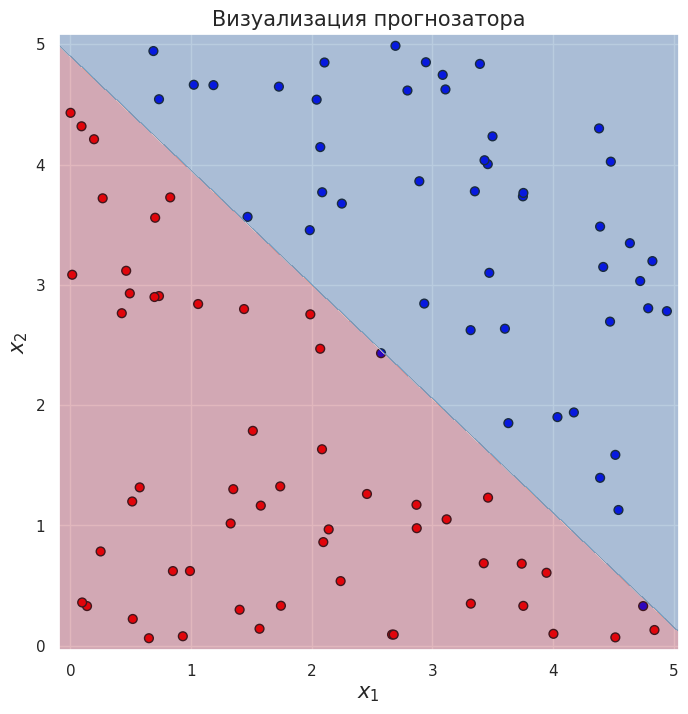

In [6]:
plot_separating_surface(X, Y, clf)

### <font color='DarkOrange'>**Задание 2 [2 баллa]**</font>
Придумайте, сгенерируйте и визуализируйте пример (рекомендуется использовать написанную выше функцию plot_separating_surface), в котором логистическая регрессия будет плохо классифицировать данные.


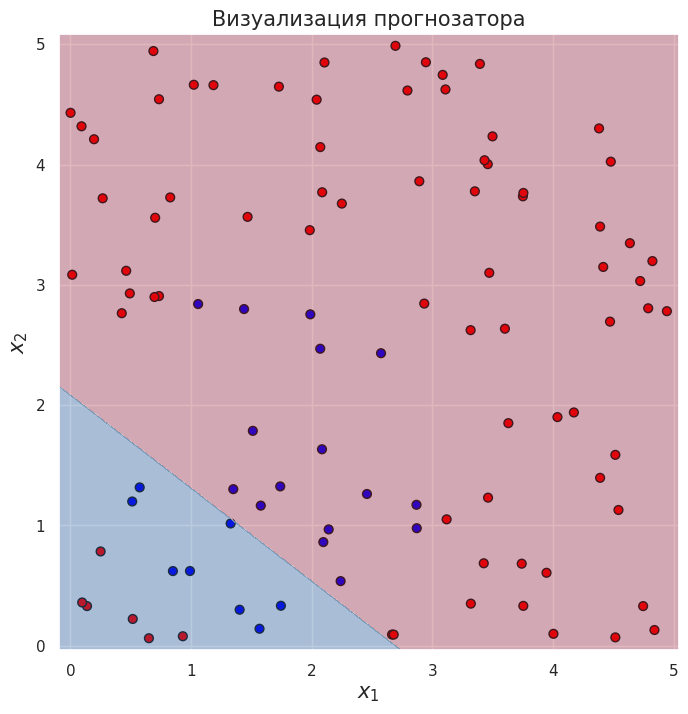

In [9]:
np.random.seed(1)
X1 = np.random.uniform(0, 5, 100)
X2 = np.random.uniform(0, 5, 100)
X = np.hstack((X1[:, None], X2[:, None]))
Y = np.where(np.sin(X1) + np.sin(X2) < 1, 0, 1)
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l2')
clf.fit(X, Y)
plot_separating_surface(X, Y, clf)

<font color='MediumOrchid'>**Ваш ответ тут (для доп. комментариев):**</font>

Можно взять границу разделения нелинейную: 

$y(x_1, x_2)= 
\begin{cases}
0, & sin(x_1) + sin(x_2) < 1; \\
1, & \text{иначе.}
\end{cases}$

так как поверхности всех классов невыпуклые, логистическая регрессия будет плохо предсказывать границу разделения.

## Обучение на реальных данных

Рассмотрим набор данных от метеорологической службы одной страны. В нём требуется предсказать, будет ли дождь на следующий день.

Для начала, скачаем данные

In [10]:
# !gdown 1AgUMxgMK-eRjzthevCk9g-J_s2vpBFpe

In [11]:
df = pd.read_csv("weatherAUS.csv")
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


### <font color='DarkOrange'>**Задание 3 [1 балл]**</font>

Что это за страна? Подсказка: жители этой страны воспользовались бы методом tail вместо head :)

<font color='MediumOrchid'>**Ваш ответ тут:**</font> Австралия

Извлечём немного информации из набора данных

In [12]:
df.shape

(145460, 23)

In [13]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

Внимательно приглядимся к столбцам. Напомним, что мы предсказываем значение RainTomorrow. Давайте посмотрим, на этот столбец

In [14]:
df['RainTomorrow'].unique()

array(['No', 'Yes', nan], dtype=object)

Целевая переменная содержит неопределённые значения! Их нужно удалить из всей выборки. Также, переименуем 'Yes' и 'No' в $1$ и $0$.

In [15]:
df = df[df['RainTomorrow'] == df['RainTomorrow']]
df['RainTomorrow'].unique()

array(['No', 'Yes'], dtype=object)

In [16]:
df['RainTomorrow'] = df['RainTomorrow'].map({'Yes': 1., 'No': 0.})
df['RainToday'] = df['RainToday'].map({'Yes': 1., 'No': 0.})

In [17]:
print(df.shape)

(142193, 23)


Объектов стало чуть-чуть поменьше. Давайте выведем немного информации о них

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 142193 entries, 0 to 145458
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustDir    132863 non-null  object 
 8   WindGustSpeed  132923 non-null  float64
 9   WindDir9am     132180 non-null  object 
 10  WindDir3pm     138415 non-null  object 
 11  WindSpeed9am   140845 non-null  float64
 12  WindSpeed3pm   139563 non-null  float64
 13  Humidity9am    140419 non-null  float64
 14  Humidity3pm    138583 non-null  float64
 15  Pressure9am    128179 non-null  float64
 16  Pressure3pm    128212 non-null  float64
 17  Cloud9am       88536 non-null   fl

Как видим, у нас есть 17 признаков имеющих вещественные значения (вещественные признаки), и 5 признаков типа object (категориальные признаки). Для них требуется отдельная предобработка. Пока разобьём выборку на обучающую и тестовую.

In [19]:
from sklearn.model_selection import train_test_split

<img src="https://img.devrant.com/devrant/rant/r_2416968_UUKQJ.jpg" width=360 height=760 />

In [20]:
y = df.RainTomorrow
X = df.drop(columns=["RainTomorrow"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2024)

In [21]:
X_train.shape

(99535, 22)

#### Вещественные признаки

Как вы могли заметить, среди вещественных и категориальных признаков есть пропущенные значения. В случае с вещественными признаками, пропущенные значения заполняют средним, медианой, нулём или даже пытаются предсказывать по другим признакам. Мы заполним медианой

In [22]:
numeric_data = X_train.select_dtypes([np.number])
numeric_data_median = numeric_data.median()
numeric_features = numeric_data.columns
X_train = X_train.fillna(numeric_data_median)
X_test = X_test.fillna(numeric_data_median)

In [23]:
len(numeric_features)

17

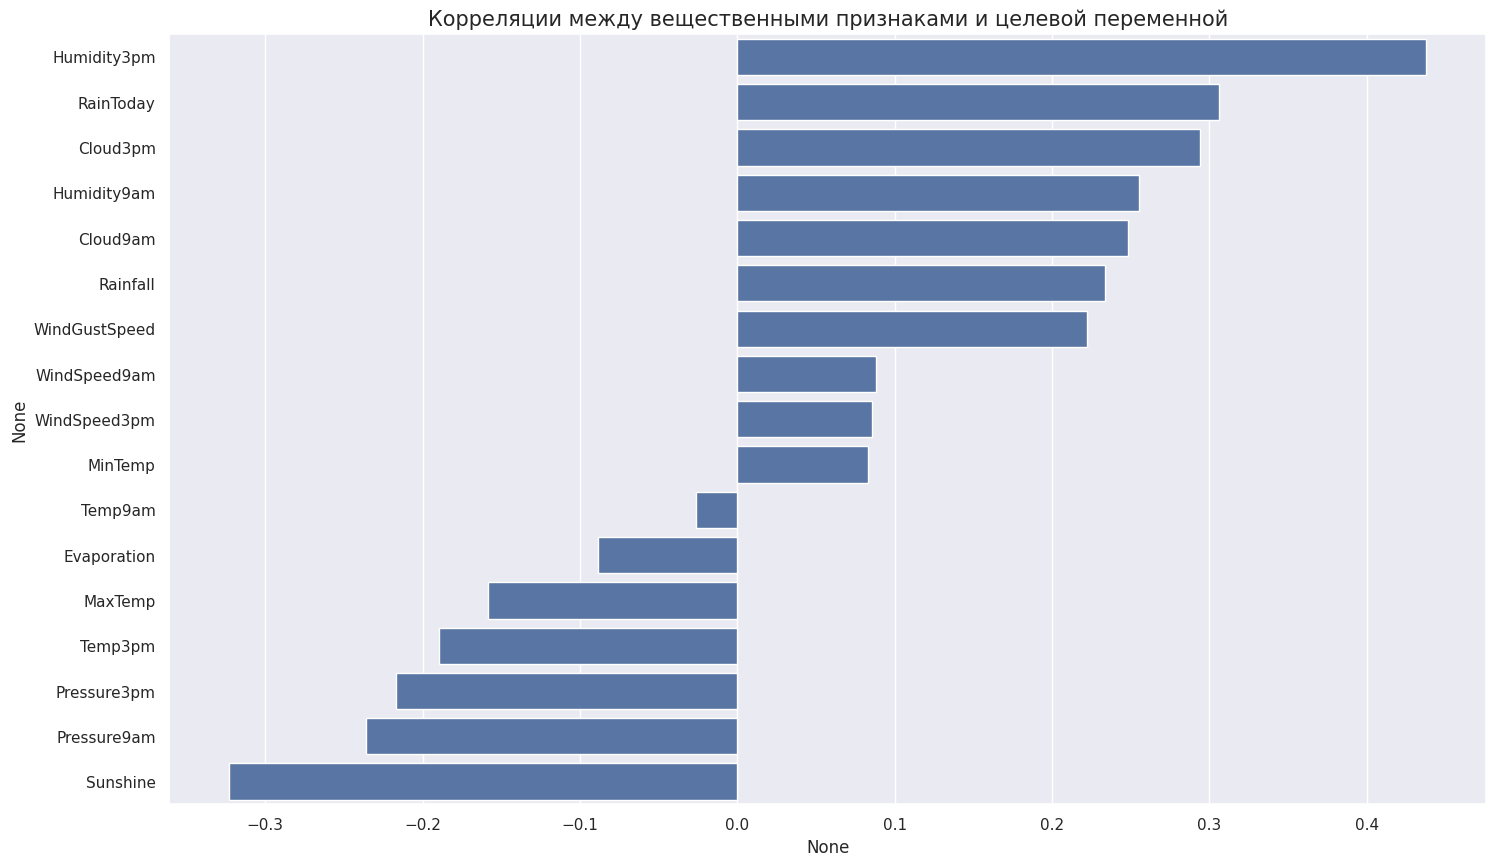

In [24]:
correlations = X_train[numeric_features].corrwith(y_train).sort_values(ascending=False)
plot = sns.barplot(y=correlations.index, x=correlations)
plot.set_title("Корреляции между вещественными признаками и целевой переменной", size=15)
plot.figure.set_size_inches(17, 10)

### <font color='DarkOrange'>**Задание 4 [2 баллa]**</font>

Попробуйте объяснить для каких-нибудь признаков получившиеся значения корреляции (почему для одних эти значения высокие, а для других низкие)?

<font color='MediumOrchid'>**Ваш ответ тут:**</font>

Мы предсказываем дождь на завтрашний день. По графику можно заметить, что целевая переменная имеет большую положительную корреляцию с признаком влажности воздуха в 15:00(Humidity3pm), что является логичным для предсказания дождя, а также целевая переменная имеет большую по модулю отрицательную корреляцию с признаком солнечного света (Sunshine), что тоже логично, если не солнечно сегодня, то  вероятность дождя завтра выше, чем если бы было солнечно.


Целевая переменная не сильно коррелирует с признаком минимальная температура сегодня (MinTemp), что скорее всего не очень влияет на дождь 

----

Дополнительно визуализируем признаки Sunshine и Humidity3pm. Библиотека seaborn предоставляет график swarmplot, который в отличие от scatterplot старается разместить на графике как можно больше точек, так чтобы они не пересекались, уложившись при этом в заданную ширину.

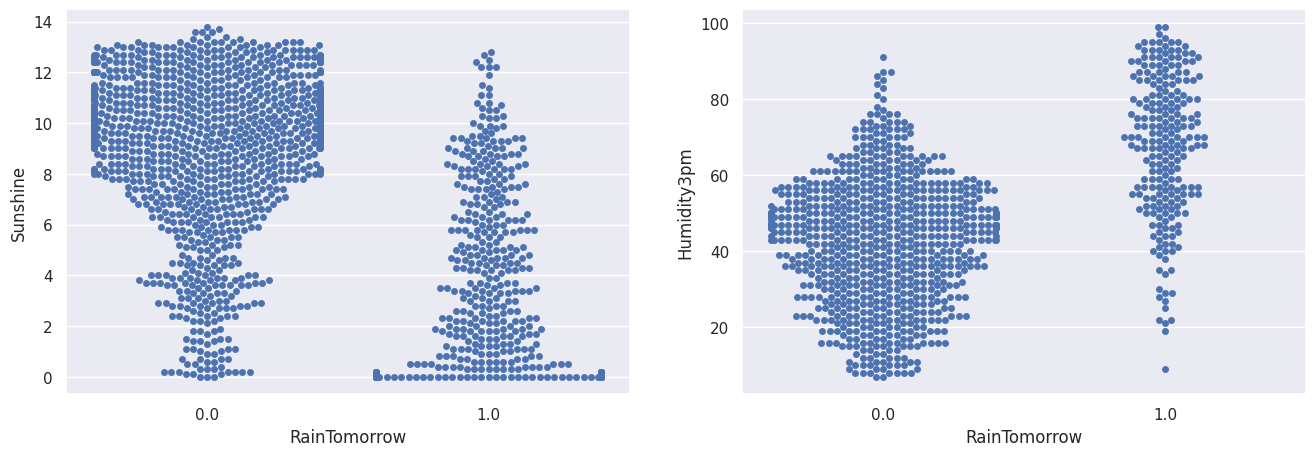

In [25]:
fig, axs = plt.subplots(figsize=(16, 5), nrows=1, ncols=2)
_ = sns.swarmplot(x="RainTomorrow", y="Sunshine", data=df.head(10000), ax=axs[0])
_ = sns.swarmplot(x="RainTomorrow", y="Humidity3pm", data=df.head(1000), ax=axs[1])

Для оценки качества классификации воспользуемся реализованными в sklearn logloss и ROC AUC. ROC AUC является метрикой по умолчанию для бинарной классификации, поскольку очень устойчива к несбалансированности классов. Подробнее про неё можно прочитать https://alexanderdyakonov.wordpress.com/2017/07/28/auc-roc-площадь-под-кривой-ошибок/ . Обучим  логистическую регрессию на вещественных признаках, не подбирая константу регуляризации

In [7]:
from sklearn.metrics import log_loss, roc_auc_score

In [8]:
model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train[numeric_features], y_train)

NameError: name 'X_train' is not defined

In [28]:
y_pred = model.predict_proba(X_test[numeric_features])[:, 1]
y_train_pred = model.predict_proba(X_train[numeric_features])[:, 1]

print("Test logloss = %.4f" % log_loss(y_test, y_pred))
print("Train logloss = %.4f" % log_loss(y_train, y_train_pred))
print("Test roc auc score = %.4f" % roc_auc_score(y_test, y_pred))
print("Train roc auc score = %.4f" % roc_auc_score(y_train, y_train_pred))

Test logloss = 0.3635
Train logloss = 0.3695
Test roc auc score = 0.8604
Train roc auc score = 0.8564


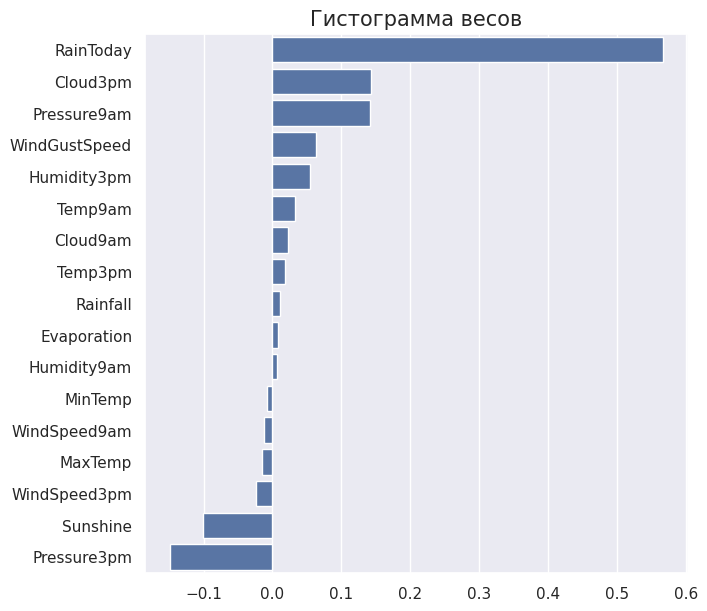

In [29]:
plt.figure(figsize=(7, 7))
sorted_weights = sorted(zip(model.coef_[0], numeric_features), reverse=True)
weights = [x[0] for x in sorted_weights]
features = [x[1] for x in sorted_weights]
_ = sns.barplot(y=features, x=weights).set_title("Гистограмма весов", size=15)

Если приглядеться к весам, то можно увидеть, что между корреляциями признаков с целевой переменной и значением соответствующих весов мало общего. Чтобы это предотвратить, будем масштабировать наши признаки перед обучением модели. Это, среди, прочего, сделает нашу регуляризацию более честной: теперь все признаки будут регуляризоваться в равной степени.

In [30]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_features])
X_test_scaled = scaler.transform(X_test[numeric_features])

In [31]:
model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

In [32]:
y_pred = model.predict_proba(X_test_scaled)[:, 1]
y_train_pred = model.predict_proba(X_train_scaled)[:, 1]

print("Test logloss = %.4f" % log_loss(y_test, y_pred))
print("Train logloss = %.4f" % log_loss(y_train, y_train_pred))
print("Test roc auc score = %.4f" % roc_auc_score(y_test, y_pred))
print("Train roc auc score = %.4f" % roc_auc_score(y_train, y_train_pred))

Test logloss = 0.3589
Train logloss = 0.3637
Test roc auc score = 0.8652
Train roc auc score = 0.8623


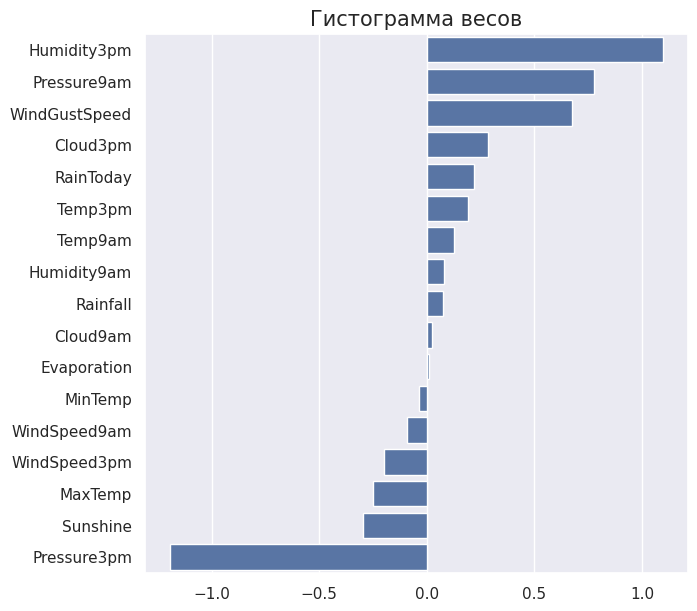

In [33]:
plt.figure(figsize=(7, 7))
sorted_weights = sorted(zip(model.coef_[0], numeric_features), reverse=True)
weights = [x[0] for x in sorted_weights]
features = [x[1] for x in sorted_weights]
_ = sns.barplot(y=features, x=weights).set_title("Гистограмма весов", size=15)

### <font color='DarkOrange'>**Задание 5 [1 балл]**</font>

Почему даже после нормализации график не до конца похож на гистограмму корреляций?

<font color='MediumOrchid'>**Ваш ответ тут:**</font> 
Так как на гистограмме корреляция переменных признаки учитываются по отдельности, а не в совокупности. Поэтому некоторые признаки могут быть слишком завышены или занижены.

Рассмотрим теперь категориальные признаки. Сразу отметим, что признак "Date" очень опасен, и лучше пока его выкинуть. Это связано с тем, что мы можем получить прямую информацию о том, будет ли завтра дождь, если текущее место и завтрашняя дата встречались где-то в обучающей выборке. Очень часто также встречаются признак наподобие "ID", которые могут содержать аналогичные утечки информации. С такими признаками всегда нужно обращаться осторожно!

In [34]:
categorical = list(X_train.drop(columns=["Date"]).dtypes[X_train.dtypes == "object"].index)
X_train[categorical] = X_train[categorical].fillna("NotGiven")
X_test[categorical] = X_test[categorical].fillna("NotGiven")

Для работы с категориальными признаками нужно их как-то закодировать числами. Для этого воспользуемся реализацией one-hot кодирования из библиотеки sklearn

In [35]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe', column_transformer),
    ('classification', LogisticRegression(solver='lbfgs', max_iter=200))
])

model = pipeline.fit(X_train.drop(columns=["Date"]), y_train)
y_pred = model.predict_proba(X_test.drop(columns=["Date"]))[:, 1]
print("Test logloss = %.6f" % log_loss(y_test, y_pred))
print("Test roc auc score = %.6f" % roc_auc_score(y_test, y_pred))

Test logloss = 0.349788
Test roc auc score = 0.872092


Качество немного выросло, если смотреть на ROC AUC!

### <font color='DarkOrange'>**Задание 6 [1 балл]**</font>

Почему итоговое качество выросло?

<font color='MediumOrchid'>**Ваш ответ тут:**</font>

Так как прибавилось количество признаков, теперь есть и категориальные, от которых тоже может зависеть целевая переменная. Также была предобработка пропущенных значений. Теперь наша модель лучше обучена, на всех признаках.

### <font color='DarkOrange'>**Задание 7 [2 баллa]**</font>

Попробуйте улучшить качество модели, попробовав другие гиперпараметры (например, число итераций, метод оптимизации, константу регуляризации и т.д.). Измерьте получившийся результат и напишите, благодаря чему удалось или не удалось улучшить текущие метрики

In [36]:
from sklearn.model_selection import GridSearchCV

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe', column_transformer),
    ('classification', LogisticRegression())
])

params = {
    'classification__solver': ['liblinear', 'lbfgs'],  
    'classification__C': [1, 5],  
    'classification__max_iter': [200, 500],  
    'classification__penalty': ['l2', 'l1', 'elasticnet'], 
}

grid = GridSearchCV(pipeline, params, cv = 4, scoring='roc_auc')
grid.fit(X_train.drop(columns=["Date"]), y_train)
y_pred = grid.predict_proba(X_test.drop(columns=["Date"]))[:, 1]
print("Test logloss = %.6f" % log_loss(y_test, y_pred))
print("Test roc auc score = %.6f" % roc_auc_score(y_test, y_pred))


Test logloss = 0.349780
Test roc auc score = 0.872103


In [37]:
grid.best_params_

{'classification__C': 1,
 'classification__max_iter': 200,
 'classification__penalty': 'l1',
 'classification__solver': 'liblinear'}

In [39]:
for elem in zip (grid.cv_results_['params'], grid.cv_results_['mean_test_score']):
  print(elem)

({'classification__C': 1, 'classification__max_iter': 200, 'classification__penalty': 'l2', 'classification__solver': 'liblinear'}, 0.8698640658238295)
({'classification__C': 1, 'classification__max_iter': 200, 'classification__penalty': 'l2', 'classification__solver': 'lbfgs'}, 0.8698638735134984)
({'classification__C': 1, 'classification__max_iter': 200, 'classification__penalty': 'l1', 'classification__solver': 'liblinear'}, 0.8698782607435183)
({'classification__C': 1, 'classification__max_iter': 200, 'classification__penalty': 'l1', 'classification__solver': 'lbfgs'}, nan)
({'classification__C': 1, 'classification__max_iter': 200, 'classification__penalty': 'elasticnet', 'classification__solver': 'liblinear'}, nan)
({'classification__C': 1, 'classification__max_iter': 200, 'classification__penalty': 'elasticnet', 'classification__solver': 'lbfgs'}, nan)
({'classification__C': 1, 'classification__max_iter': 500, 'classification__penalty': 'l2', 'classification__solver': 'liblinear'

<font color='MediumOrchid'>**Ваш ответ тут:**</font>

Рассмотрим точность модели до 6 знаков после запятой, чтобы сравнивать: 

Качество было: 
**Test logloss = 0.349788**

**Test roc auc score = 0.872092**

Получили качество модели: 

**Test logloss = 0.349780**

**Test roc auc score = 0.872103**

Качество модели увеличилось, хоть и на немного. **Уменьшился log_loss и увеличился auc_score**. Лучшие параметры из мною выбранных для GridSearchCV:

'classification__C': **1**, - константа регуляризации = 1

 'classification__max_iter': **500**, количество макс. итераций

 'classification__penalty': **'l1'**, LASSO регуляризация
 
 'classification__solver': **'liblinear'**  алгоритм liblinear, он как раз является хорошим для бинарной классификаций


**Выводы** Во второй части задания по линейным моделям мы должны были узнать:
.

1.   Зачем нужно нормализовать данные.
2.   Как работать с вещественными и категориальными признаками.
3.   Как интерпретировать результат обучения линейной модели, опираясь на описание обучающих данных